# K-Means Algorithm

The general idea of clustering is to group data with similar traits. The main benefit of this is the ability to extract information from new data because you know what it is most similar to, thus giving you valuable insight. In the field of machine learning, this is considered unsupervised learning because it requires no labels on the data -- the algorithm auto assigns clusters, and you infer behavior off of those clusters.

Clustering has many applications such as image segmentation, preference predictions, compression, model fitting.

Although you can trace the idea of k-means clustering back to 1967 with a paper by Hugo Steinhaus, James MacQueen was the first to coin the term k-means in 1956. MacQueen's paper title "Some Methods For Classification and Analysis of Multivariate Observations" goes over the k-means process that segments an N-dimensional population into k sets. Note: when we refer to k in the algorithm, that is the number of sets that we are dividing the population.


A great deal of MacQueens article discusses optimality for the k-means algorithm, which is an important area to discuss, especially when considering the time at which the article got published. Back in 1967, computers were very slow and expensive. Although we had proofs that can guarantee that we could find an optimal solution, they were a NP-Hard problem. This is critical because NP-Hard problems are problems that are exponential to solve.

Although the k-means algorithm did not guarantee the optimal solution, there was a subset of problems that it did guarantee an optimal solution-- the specifics of these problems got discussed later in the article. Nerveless, since this algorithm wasn't computationally expensive and generally gave good results, it was a huge breakthrough at the time. 


This algorithm can be broken down into four major segments:

## Step 1:

Pick k random points as cluster centers called centroids.

## Step 2: 

Assign each point to nearest cluster by calculating its distance to each centroid.

## Step 3: 

Find new cluster center by taking the average of the assigned points.

## Step 4:

Repeat steps 2 and 3 until no cluster assignments change.

# Python Implementation

Implementing this in python is rather straight forward. Given data, cluster it into k sets and return the cluster assignments and cluster values.

In [1]:
import sys
import numpy as np

def distToClust(val, clusterCenter):
    """
    Distance measure to cluster, can change
    this to be different types of distances
    """
    return np.linalg.norm(val-clusterCenter)


def closestCenter(val, clusters):
    """
    Finds the cluster closest to the presented
    value
    """
    curMin = sys.maxsize
    curIndex = 0    
    for k in range(0, len(clusters)):
        d = distToClust(val, clusters[k])
        if d < curMin:
            curIndex = k
            curMin = d
    return curIndex


def kmeansAlgo(k, data):
    """
    k: number of clusters
    data: nxd numpy matrix where n is number of elements
          and d is the number of dimensions in the data.  
    
    return: tuple of assignments and clusters where clusters
    is a list of clusteroids and assignments maps each value
    to a single cluster
    """
    
    n = data.shape[0] # length of data to cluster
    d = data.shape[1] # dimensionality of data
    
    # maps each element in data to a cluster
    assignments = np.zeros(n, dtype=np.int) 
    
    clusters = []
    for i in range(0, k):
        clusters.append(data[i])
    
    reAssigned = True
    generations = 0
    while reAssigned:
        reAssigned = False
        
        # assign clusters
        for i in range(0, n):
            c = closestCenter(data[i], clusters)
            if c != assignments[i]:
                reAssigned = True
                assignments[i] = c
                
        # re-compute centers
        clusterValues = []
        for _ in range(0, k):
            clusterValues.append([])
        for i in range(0, n):
            clusterValues[assignments[i]].append(data[i])
        for i in range(0, k):
            clusters[i] = np.average(clusterValues[i], axis=0)
        generations = generations + 1
    print("Clustering took " + str(generations) + " generations")
    return assignments, clusters

# Image Segmentation

Using our k-means algorithm we can cluster the pixels in an image together.

## Clustering on Color

When we cluster the pixels of an image based on color, we map pixels with similar color to the same cluster. Since an image is a three dimensional matrix, we can do this just fine. When clustering our data, the input is going to just be the list of pixel values. Note: as far as the k-means algorithm is conserned, there is no coordinates, just a list of pixels. The RGB values of the pixels gets clustered together. 

To make things run a bit faster, we are going to be using the k-means implementation from sklearn.

In [20]:
def segmentImgClrRGB(imgFilename, k):

    #1. Load the image 
    img = cv2.imread(imgFilename)
    
    h = img.shape[0]
    w = img.shape[1]
    
    img.shape = (img.shape[0] * img.shape[1], 3)
    
    #5. Run k-means on the vectorized reponses X to get a vector of labels (the clusters); 
    #  
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img).labels_
    
    #6. Reshape the label results of k-means so that it has the same size as the input image
    #   Return the label image which we call idx
    kmeans.shape = (h, w)

    return kmeans

After we have our pixel assignment we, want some useful way to display it. In this algorithm we are coloring in each pixel with the assignments's clusteroid center. IE: if our algorithm ran with three clusters, the new image would only have three colors in it.

In [7]:
import skimage
from sklearn.cluster import KMeans
from numpy import linalg as LA

def colorClustering(idx, imgFilename, k):
    img = cv2.imread(imgFilename)
    
    clusterValues = []
    for _ in range(0, k):
        clusterValues.append([])
    
    for r in range(0, idx.shape[0]):
        for c in range(0, idx.shape[1]):
            clusterValues[idx[r][c]].append(img[r][c])

    imgC = np.copy(img)

    clusterAverages = []
    for i in range(0, k):
#         print(len(clusterValues[i])/(idx.shape[1]*idx.shape[0]))
        clusterAverages.append(np.average(clusterValues[i], axis=0))
    
    for r in range(0, idx.shape[0]):
        for c in range(0, idx.shape[1]):
            imgC[r][c] = clusterAverages[idx[r][c]]
            
    return imgC

Next we need a way of printing the images, I usually use matplot lib. I'm also displaying the image that we are going to be using for the clutering.

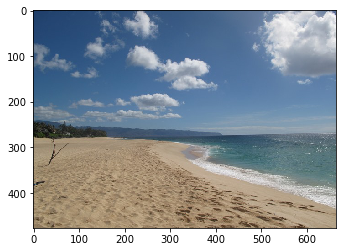

In [9]:
import cv2
import matplotlib.pyplot as plt 

def printI(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)

printI(cv2.imread("bg.jpg"))

***Segmentation done***


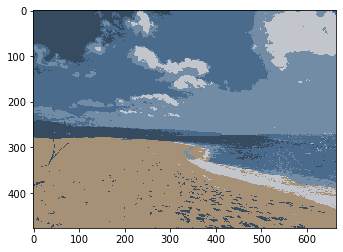

In [11]:
idx = segmentImgClrRGB("bg.jpg", 5)
res = colorClustering(idx, "bg.jpg", 5)
printI(res)

Just like you can segment with RGB values, you can also try different color spaces such as HSV. Playing around with the distance measure would also give you different results.



## Texture Clustering

Similarly to color segmentation, you can cluster based on texture detection. The premis of this method is that you generate a bunch of filters of different shapes, sizes, and scales. When you apply this filter bank to a pixel, it will have similar responses as pixels in regions with a similar texture.


The first step is to construct a filter bank.

In [12]:
'''
The Leung-Malik (LM) Filter Bank, implementation in python

T. Leung and J. Malik. Representing and recognizing the visual appearance of
materials using three-dimensional textons. International Journal of Computer
Vision, 43(1):29-44, June 2001.

Reference: http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
'''

def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    return F


Now that we have our filters we are going to display them to verify that they are what we expect.

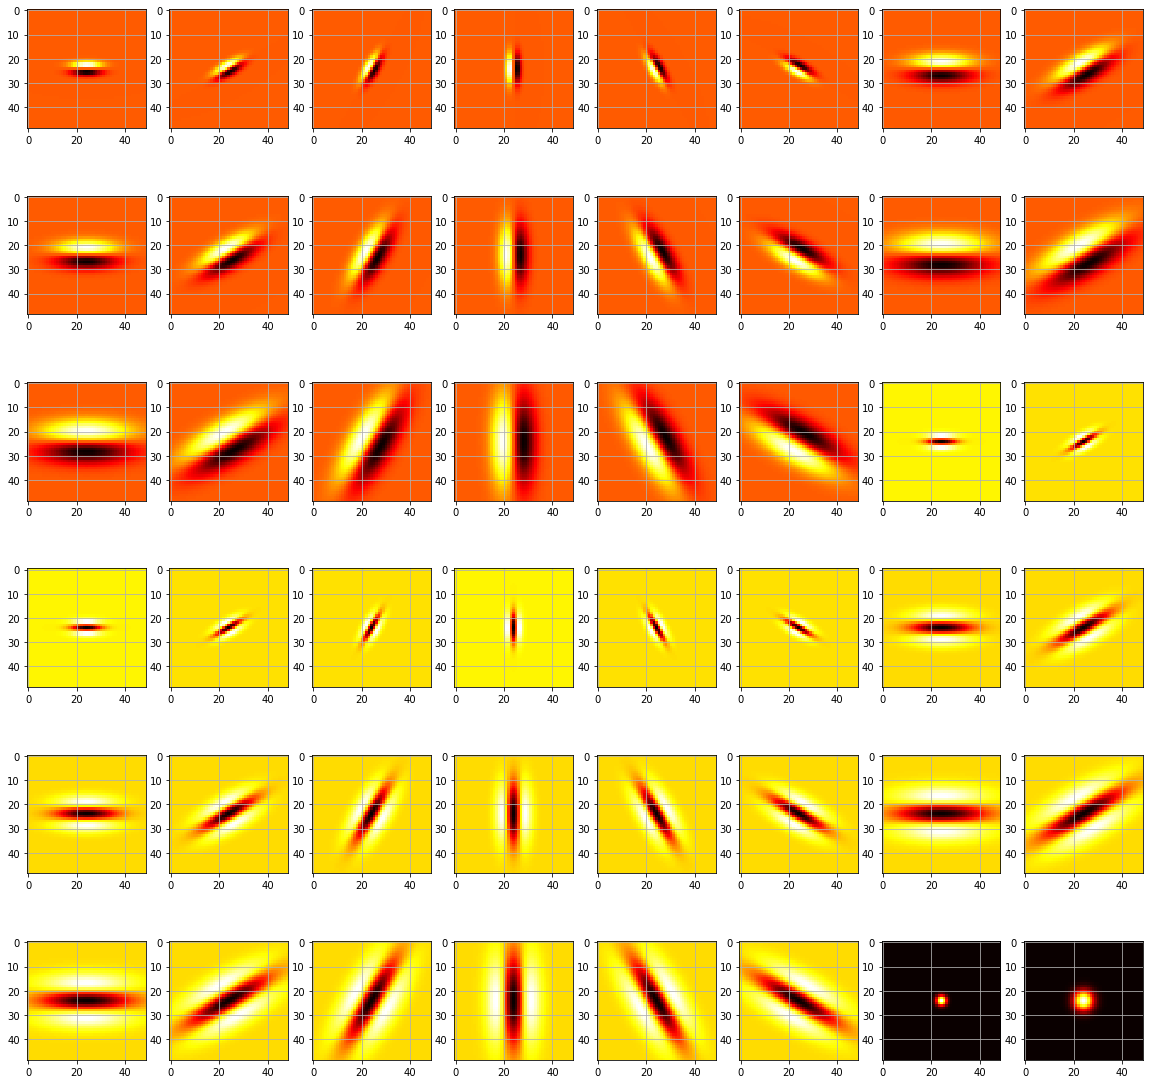

In [13]:
def displayFilterBank():
    
    fig, axs = plt.subplots(6, 8, figsize=(20,20))
    F = makeLMfilters()
    for row in range(0, 6):
        for col in range(0, 8):
            f = F[:, :, row * 6 + col]
            axs[row][col].imshow(f, cmap='hot', interpolation='nearest')
            axs[row][col].grid(True)
#     plt.show()
    plt.savefig('filters.png')
displayFilterBank()

With the filter bank we can now start clustering based on the responses from each filter response. When we clustered with color, we had three dimensions, with our filter bank we now have 48 dimensions.

In [17]:
def generateGrayScale(image):
    w = np.array([[[ 0.25, 0.5,  0.25]]])
    gray2 = cv2.convertScaleAbs(np.sum(image*w, axis=2))
    return gray2

def segmentImg(imgFilename, clusters):
    #1. Load and display the image from which you want to segment the foreground from the background
    #  Make sure to convert your image to grayscale after loading
    img = cv2.imread(imgFilename)
    h = img.shape[0]
    w = img.shape[1]
    gImg =  generateGrayScale(img)
    printI(gImg)
    
    #2. Create an overcomplete bank of filters F
    F = makeLMfilters()
    
    s = F.shape
    
    #3. Convolve the input image with every filter in the bank of filters 
    responses = [None] * s[2]
    for k in range(0, s[2]):
        fb = F[:, :,k]
        response = cv2.filter2D(gImg,-1, fb)
        responses[k] = response
    
        
    #4.Take the absolute values of the responses and 
    #  reshape the reponse tensor into a matrix of size [row*cols, num_filters]
    a = np.zeros((h*w, s[2]), dtype=np.float)
    
    for r in range(0, h):
        for c in range(0, w):
            for f in range(0, s[2]):
                t = abs(responses[f][r][c])
                a[r * w + c][f] = abs(responses[f][r][c])

    #5. Run k-means on the vectorized reponses X to get a vector of labels (the clusters); 
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(a).labels_    
    
    #6. Reshape the label results of k-means so that it has the same size as the input image
    #   Return the label image which we call idx
    kmeans.shape = (h, w)

    return kmeans


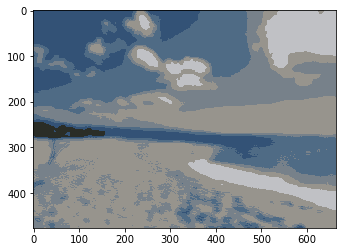

In [19]:
idx1 = segmentImg("bg.jpg",6)
res1 = colorClustering(idx1, "bg.jpg", 6)
printI(res1)

With the texture clustering, you can see that part of the ocean was in the same cluster as part of the sky or beach. This is to be expected because they were clustered on texture and not color. When doing texture  detection a common thing to pick up is blurryness. This maxes texture clustering useful for things like background removal when your foreground is in focus and the background is blurred. 

# Takaways

Due to the k-means algorithm not always converting on an optimum answer and being profoundly affected by outlines, it is rarely used by itself. However, it frequently used to bootstrap and influence other algorithms.
As the MacQueen stated initially in his article, "there is no feasible, general method which always yield an optimal partition." Due to the nature of NP-Hard problems, this fact is unlikely to change anytime soon. More recently, people have rebooted k-means to include a beam search to avoid converging on local maxima-- this process is called "k-means++" and Vassilvitskii outlines it in his  2007 paper titled "K-means++: the advantages of careful seeding".

Another major question in this field of research research is: how do we choose k? Newer work with k-means and other clustering techniques look into how we can automatically select a k using the elbow technique or other techniques like GVF.

K-means has had a lasting effect on the field of machine learning. Most textbooks and AI classes cover k-means clustering as a starting point when teaching people about unsupervised learning. Moreover, algorithms to this day are still using k-means as a tool behind the scenes to pre-process data before it gets fed to the next step in the data pipeline. 
